In [1]:
import numpy as np
from numpy import random
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import load_model
#print("hai")

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 10} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)


train_path='train'
test_path='test'
valid_path='validation'

In [3]:
dataset=np.load('/home/workstation/Desktop/jab/MHCR/datasetgray.npy')

In [4]:

def generator(features, labels, batch_size):
    batch_features = np.zeros((batch_size, 86,86,1))
    batch_labels = np.zeros((batch_size,44))
    
    while True:
        for i in range(batch_size):
     # choose random index in features
            index= random.choice(len(features),1)
            batch_features[i] = features[index]
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

In [5]:
random.shuffle(dataset)
X=np.array([i[0]for i in dataset]).reshape(-1,86,86,1)
y=np.array([i[1] for i in dataset])
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)



(73521, 86, 86, 1) (18381, 86, 86, 1) (73521, 44) (18381, 44)
(58816, 86, 86, 1) (14705, 86, 86, 1) (58816, 44) (14705, 44)


In [6]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
#imgs,labels=next(train_batches)
#imgs,labels=next(generator(X_train,y_train,500))

In [7]:

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=[86, 86, 1]))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Conv2D(64,3, activation='relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(44, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 84, 84, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       73856     
__________

In [ ]:
'''model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(86, 86, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(44, activation='softmax'))
model2.summary()
'''

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model2.fit_generator(generator(X_train,y_train,200),steps_per_epoch=450,validation_data=generator(X_val,y_val,147),validation_steps=100,epochs=10,verbose=1)

In [16]:
 model.fit_generator(generator(X_train,y_train,200),steps_per_epoch=450,validation_data=generator(X_val,y_val,140),validation_steps=100,epochs=1,verbose=1)

Epoch 1/1
450/450 [==============================] - 88s 195ms/step - loss: 0.3729 - acc: 0.9646 - val_loss: 0.5094 - val_acc: 0.9275


In [ ]:
#np.save('/home/workstation/Desktop/jab/MHCR/testfile.npy',dataset[-18381:])
#del model2

In [ ]:
#tdata=np.load('/home/workstation/Desktop/jab/MHCR/testfile.npy')
#print(tdata.shape)

In [10]:
def get_confusion_matrix_one_hot(model_results, truth):
        '''model_results and truth should be for one-hot format, i.e, have >= 2 columns,
        where truth is 0/1, and max along each row of model_results is model result
        '''
        assert model_results.shape == truth.shape
        num_outputs = truth.shape[1]
        confusion_matrix = np.zeros((num_outputs, num_outputs), dtype=np.int32)
        predictions = np.argmax(model_results,axis=1)
        assert len(predictions)==truth.shape[0]

        for actual_class in range(num_outputs):
            idx_examples_this_class = truth[:,actual_class]==1
            prediction_for_this_class = predictions[idx_examples_this_class]
            for predicted_class in range(num_outputs):
                count = np.sum(prediction_for_this_class==predicted_class)
                confusion_matrix[actual_class, predicted_class] = count
        assert np.sum(confusion_matrix)==len(truth)
        assert np.sum(confusion_matrix)==np.sum(truth)
        return confusion_matrix

In [17]:
predict=model.predict(X_test)

In [18]:
con_mat=get_confusion_matrix_one_hot(predict,y_test)
print(X_test.shape)
print(con_mat)

(18381, 86, 86, 1)
[[339  20   0 ...   0   0   2]
 [  0 415   0 ...   0   0   0]
 [  0   0 395 ...   0   0   0]
 ...
 [  0   0   0 ... 398   0   0]
 [  0   0   0 ...   0 400   0]
 [  0   0   0 ...   0   0 426]]


In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [14]:
names=['ch'+str(i+1) for i in range(44)]

In [21]:
plot_confusion_matrix(cm           = con_mat, 
                      normalize    = False,
                      target_names = names,
                      title        = "Confusion Matrix")

In [ ]:
#from keras import backend as K
#K.clear_session()

In [26]:
#model2.save('/home/workstation/Desktop/jab/MHCR/modelMHCR_gray_3_84_2.h5')

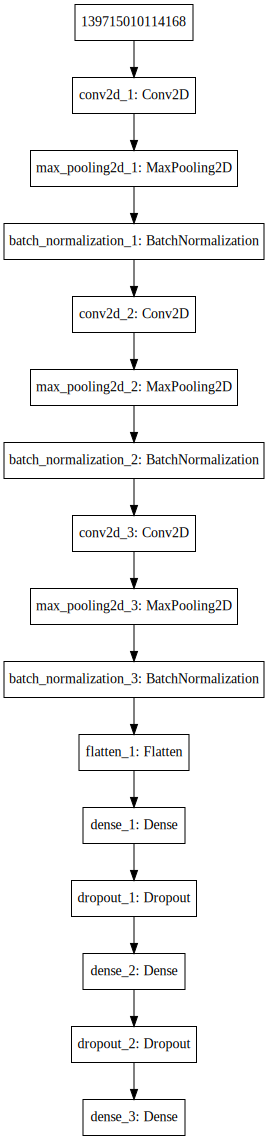

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))